In [14]:
from google.colab import files

uploaded = files.upload()

Saving Feature.xlsx to Feature (1).xlsx
Saving POS_test.csv to POS_test (1).csv
Saving POS_train_val.csv to POS_train_val (1).csv


In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb  # ✅ LightGBM 대신 XGBoost 사용

FEATURE_PATH = "Feature.xlsx"
TRAIN_PATH   = "POS_train_val.csv"
TEST_PATH    = "POS_test.csv"

# =========================
# 1. 유틸 함수들
# =========================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    ) * 100


def calculate_operating_hours(row):
    """
    학기/방학 + 요일 + 공휴일 기준 운영시간 계산
    """
    weekday = row["weekday"]
    semester = row["semester"]
    holiday = row["holiday"]

    # 일요일 미운영
    if weekday == "sun":
        return 0

    # 학기 중
    if semester == 1:
        if holiday == 1:
            return 7  # 공휴일 7시간
        if weekday in ["mon", "tue", "wed", "thu", "fri"]:
            return 12  # 평일 12시간
        if weekday == "sat":
            return 7
        return 0

    # 방학 중
    else:
        if holiday == 1:
            return 0
        if weekday in ["mon", "tue", "wed", "thu", "fri", "sat"]:
            return 7
        return 0


# =========================
# 2. 메인 파이프라인
# =========================
def run_xgb(feature_path=FEATURE_PATH, train_path=TRAIN_PATH, test_path=TEST_PATH):

    # ---------- (1) 데이터 로드 ----------
    feat = pd.read_excel(feature_path)
    pos_train = pd.read_csv(train_path)
    pos_test = pd.read_csv(test_path)

    # 숫자 전처리
    for df in [pos_train, pos_test]:
        for col in ["daily", "AOV"]:
            df[col] = (
                df[col].astype(str).str.replace(",", "", regex=False).astype(float)
            )
        df["date"] = pd.to_datetime(df["date"])

    feat["date"] = pd.to_datetime(feat["date"])

    # train/test 구분 플래그 추가 후 concat
    pos_train["set"] = "train"
    pos_test["set"] = "test"
    pos_all = pd.concat([pos_train, pos_test], ignore_index=True)

    # Feature와 merge
    df_all = pd.merge(pos_all, feat, on="date", how="left")
    df_all = df_all.sort_values("date").reset_index(drop=True)

    print("All merged shape:", df_all.shape)
    print(df_all.head())

    # ---------- (2) Feature Engineering ----------
    # 2-1. 운영시간
    df_all["operating_hours"] = df_all.apply(calculate_operating_hours, axis=1)

    # 2-2. 시험 window (optional)
    df_all["exam_before3"] = df_all["exam"].shift(1).rolling(3, min_periods=1).sum().fillna(0)
    df_all["exam_after3"] = df_all["exam"].shift(-1).rolling(3, min_periods=1).sum().fillna(0)

    # 2-3. 학기 × 주말 교차
    df_all["semester_weekend"] = df_all["semester"] * df_all["weekend"]

    # 2-4. Lag Features (지연값)
    lag_list = [1, 2, 3, 7, 14, 28]
    for lag in lag_list:
        df_all[f"Lag{lag}"] = df_all["daily"].shift(lag)

    # 2-5. Rolling Mean / Std (이동 평균 / 표준편차)
    win_list = [7, 14, 28]
    for win in win_list:
        roll = df_all["daily"].rolling(window=win, min_periods=1)
        # 현재 날 정보는 쓰지 않도록 shift(1)
        df_all[f"RollingMean{win}"] = roll.mean().shift(1)
        df_all[f"RollingStd{win}"] = roll.std(ddof=0).shift(1)

    # 2-6. weekday one-hot
    df_all = pd.get_dummies(df_all, columns=["weekday"], drop_first=True)

    print("\nAfter feature engineering:")
    print(df_all.head())

    # ---------- (3) Train / Test 분리 ----------
    # NaN 있는 행 제거 (Lag/Rolling 때문에 앞부분이 NaN)
    feature_na_cols = [f"Lag{l}" for l in lag_list] + \
                      [f"RollingMean{w}" for w in win_list] + \
                      [f"RollingStd{w}" for w in win_list]

    df_all_clean = df_all.dropna(subset=feature_na_cols).reset_index(drop=True)
    print("\nAfter dropping NaN from lag/rolling:", df_all_clean.shape)

    df_train_val = df_all_clean[df_all_clean["set"] == "train"].copy()
    df_test = df_all_clean[df_all_clean["set"] == "test"].copy()

    # 학습은 매출 0원 제외
    df_train_val = df_train_val[df_train_val["daily"] > 0].copy()
    print("Train_val (daily>0):", df_train_val.shape)
    print("Test (all, incl. 0 & >0):", df_test.shape)

    # ---------- (4) Train/Val Split (시간 기준 80:20) ----------
    df_sorted = df_train_val.sort_values("date").reset_index(drop=True)
    split_idx = int(len(df_sorted) * 0.8)
    train = df_sorted.iloc[:split_idx]
    val = df_sorted.iloc[split_idx:]

    drop_cols = ["date", "daily", "num", "AOV", "set"]
    feature_cols = [c for c in df_sorted.columns if c not in drop_cols]

    X_train = train[feature_cols]
    y_train = train["daily"].values
    X_val = val[feature_cols]
    y_val = val["daily"].values

    print("\nFeature columns:", len(feature_cols))
    print(feature_cols)

    # ---------- (5) XGBoost Grid Search (Val RMSE 기준) ----------
    from itertools import product

    # 튜닝할 하이퍼파라미터 후보들
    param_grid = {
        "max_depth":        [4, 5, 6],     # 트리 깊이
        "learning_rate":    [0.03, 0.05],  # 학습률 (작을수록 느리지만 안정적)
        "n_estimators":     [400, 800],    # 트리 개수
        "min_child_weight": [2, 4],        # 리프 분기 제한
        "subsample":        [0.7, 0.9],    # row sampling 비율
        "colsample_bytree": [0.7, 0.9],    # column sampling 비율
    }

    best_rmse = np.inf
    best_params = None

    print("\n===== Hyperparameter Search (based on Val RMSE, XGBoost) =====")

    for max_depth, lr, n_estimators, min_child_weight, subsample, colsample in product(
        param_grid["max_depth"],
        param_grid["learning_rate"],
        param_grid["n_estimators"],
        param_grid["min_child_weight"],
        param_grid["subsample"],
        param_grid["colsample_bytree"],
    ):
        params = {
            "objective": "reg:squarederror",
            "max_depth": max_depth,
            "learning_rate": lr,
            "n_estimators": n_estimators,
            "min_child_weight": min_child_weight,
            "subsample": subsample,
            "colsample_bytree": colsample,
            "random_state": 42,
            "n_jobs": -1,
        }

        reg_tmp = xgb.XGBRegressor(**params)

        reg_tmp.fit(X_train, y_train)
        val_pred_tmp = reg_tmp.predict(X_val)
        rmse_tmp = np.sqrt(mean_squared_error(y_val, val_pred_tmp))

        print(f"params={params} → RMSE={rmse_tmp:.4f}")

        if rmse_tmp < best_rmse:
            best_rmse = rmse_tmp
            best_params = params

    print("\n>>> Best Params (by Val RMSE):")
    print(best_params)
    print(f">>> Best Val RMSE: {best_rmse:,.4f}")

    # 🔹 최적 파라미터로 최종 모델 다시 학습
    reg = xgb.XGBRegressor(**best_params)
    reg.fit(X_train, y_train)

    # ---------- (6) Validation 평가 ----------
    val_pred = reg.predict(X_val)

    mae_val = mean_absolute_error(y_val, val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
    smape_val = smape(y_val, val_pred)

    print("\n===== Validation Performance (with Lags & Rolling, tuned XGBoost) =====")
    print(f"MAE   : {mae_val:,.2f}")
    print(f"RMSE  : {rmse_val:,.2f}")
    print(f"SMAPE : {smape_val:.2f}%")

    print("\nFeature Importances (Top 30):")
    fi = pd.Series(reg.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print(fi.head(30))

    # ---------- (7) Test 평가 (daily>0만) ----------
    df_test_eval = df_test[df_test["daily"] > 0].copy()
    if len(df_test_eval) == 0:
        print("\nNo test rows with daily>0 after lag/rolling/NaN filtering.")
        return

    X_test = df_test_eval[feature_cols]
    y_test = df_test_eval["daily"].values
    test_pred = reg.predict(X_test)

    mae_test = mean_absolute_error(y_test, test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
    smape_test = smape(y_test, test_pred)

    print("\n===== Test Performance (daily>0 only, tuned XGBoost) =====")
    print(f"MAE   : {mae_test:,.2f}")
    print(f"RMSE  : {rmse_test:,.2f}")
    print(f"SMAPE : {smape_test:.2f}%")

    result_df = pd.DataFrame({
        "date": df_test_eval["date"].values,
        "actual_daily": y_test,
        "pred_daily": test_pred
    }).sort_values("date").reset_index(drop=True)

    metrics = {
        "model": "XGB",
        "val_MAE": mae_val,
        "val_RMSE": rmse_val,
        "val_SMAPE": smape_val,
        "test_MAE": mae_test,
        "test_RMSE": rmse_test,
        "test_SMAPE": smape_test,
    }

    return metrics, result_df

if __name__ == "__main__":
    metrics, df_pred = run_xgb()
    print("\n[DEBUG] XGB metrics:", metrics)
    print(df_pred.head())

All merged shape: (875, 13)
        date  daily  num  AOV    set weekday  weekend  holiday  semester  \
0 2023-08-01    0.0  0.0  0.0  train     NaN      NaN      NaN       NaN   
1 2023-08-02    0.0  0.0  0.0  train     NaN      NaN      NaN       NaN   
2 2023-08-03    0.0  0.0  0.0  train     NaN      NaN      NaN       NaN   
3 2023-08-04    0.0  0.0  0.0  train     NaN      NaN      NaN       NaN   
4 2023-08-05    0.0  0.0  0.0  train     NaN      NaN      NaN       NaN   

   seasonal  exam  ceremony  dormitory  
0       NaN   NaN       NaN        NaN  
1       NaN   NaN       NaN        NaN  
2       NaN   NaN       NaN        NaN  
3       NaN   NaN       NaN        NaN  
4       NaN   NaN       NaN        NaN  

After feature engineering:
        date  daily  num  AOV    set  weekend  holiday  semester  seasonal  \
0 2023-08-01    0.0  0.0  0.0  train      NaN      NaN       NaN       NaN   
1 2023-08-02    0.0  0.0  0.0  train      NaN      NaN       NaN       NaN   
2 2023-

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

FEATURE_PATH = "Feature.xlsx"
TRAIN_PATH   = "POS_train_val.csv"
TEST_PATH = "POS_test.csv"

# =========================
# 1. 유틸 함수들
# =========================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    ) * 100


def calculate_operating_hours(row):
    """
    학기/방학 + 요일 + 공휴일 기준 운영시간 계산
    """
    weekday = row["weekday"]
    semester = row["semester"]
    holiday = row["holiday"]

    # 일요일 미운영
    if weekday == "sun":
        return 0

    # 학기 중
    if semester == 1:
        if holiday == 1:
            return 7  # 공휴일 7시간
        if weekday in ["mon", "tue", "wed", "thu", "fri"]:
            return 12  # 평일 12시간
        if weekday == "sat":
            return 7
        return 0

    # 방학 중
    else:
        if holiday == 1:
            return 0
        if weekday in ["mon", "tue", "wed", "thu", "fri", "sat"]:
            return 7
        return 0


# =========================
# 2. 메인 파이프라인
# =========================
def run_lgbm(feature_path=FEATURE_PATH, train_path=TRAIN_PATH, test_path=TEST_PATH):

    # ---------- (1) 데이터 로드 ----------
    feat = pd.read_excel(feature_path)
    pos_train = pd.read_csv(train_path)
    pos_test = pd.read_csv(test_path)

    # 숫자 전처리
    for df in [pos_train, pos_test]:
        for col in ["daily", "AOV"]:
            df[col] = (
                df[col].astype(str).str.replace(",", "", regex=False).astype(float)
            )
        df["date"] = pd.to_datetime(df["date"])

    feat["date"] = pd.to_datetime(feat["date"])

    # train/test 구분 플래그 추가 후 concat
    pos_train["set"] = "train"
    pos_test["set"] = "test"
    pos_all = pd.concat([pos_train, pos_test], ignore_index=True)

    # Feature와 merge
    df_all = pd.merge(pos_all, feat, on="date", how="left")
    df_all = df_all.sort_values("date").reset_index(drop=True)

    print("All merged shape:", df_all.shape)
    print(df_all.head())

    # ---------- (2) Feature Engineering ----------
    # 2-1. 운영시간
    df_all["operating_hours"] = df_all.apply(calculate_operating_hours, axis=1)

    # 2-2. 시험 window (optional)
    df_all["exam_before3"] = df_all["exam"].shift(1).rolling(3, min_periods=1).sum().fillna(0)
    df_all["exam_after3"] = df_all["exam"].shift(-1).rolling(3, min_periods=1).sum().fillna(0)

    # 2-3. 학기 × 주말 교차
    df_all["semester_weekend"] = df_all["semester"] * df_all["weekend"]

    # 2-4. Lag Features (지연값)
    lag_list = [1, 2, 3, 7, 14, 28]
    for lag in lag_list:
        df_all[f"Lag{lag}"] = df_all["daily"].shift(lag)

    # 2-5. Rolling Mean / Std (이동 평균 / 표준편차)
    win_list = [7, 14, 28]
    for win in win_list:
        roll = df_all["daily"].rolling(window=win, min_periods=1)
        # 현재 날 정보는 쓰지 않도록 shift(1)
        df_all[f"RollingMean{win}"] = roll.mean().shift(1)
        df_all[f"RollingStd{win}"] = roll.std(ddof=0).shift(1)

    # 2-6. weekday one-hot
    df_all = pd.get_dummies(df_all, columns=["weekday"], drop_first=True)

    print("\nAfter feature engineering:")
    print(df_all.head())

    # ---------- (3) Train / Test 분리 ----------
    # NaN 있는 행 제거 (Lag/Rolling 때문에 앞부분이 NaN)
    feature_na_cols = [f"Lag{l}" for l in lag_list] + \
                      [f"RollingMean{w}" for w in win_list] + \
                      [f"RollingStd{w}" for w in win_list]

    df_all_clean = df_all.dropna(subset=feature_na_cols).reset_index(drop=True)
    print("\nAfter dropping NaN from lag/rolling:", df_all_clean.shape)

    df_train_val = df_all_clean[df_all_clean["set"] == "train"].copy()
    df_test = df_all_clean[df_all_clean["set"] == "test"].copy()

    # 학습은 매출 0원 제외
    df_train_val = df_train_val[df_train_val["daily"] > 0].copy()
    print("Train_val (daily>0):", df_train_val.shape)
    print("Test (all, incl. 0 & >0):", df_test.shape)

    # ---------- (4) Train/Val Split (시간 기준 80:20) ----------
    df_sorted = df_train_val.sort_values("date").reset_index(drop=True)
    split_idx = int(len(df_sorted) * 0.8)
    train = df_sorted.iloc[:split_idx]
    val = df_sorted.iloc[split_idx:]

    drop_cols = ["date", "daily", "num", "AOV", "set"]
    feature_cols = [c for c in df_sorted.columns if c not in drop_cols]

    X_train = train[feature_cols]
    y_train = train["daily"]
    X_val = val[feature_cols]
    y_val = val["daily"]

    print("\nFeature columns:", len(feature_cols))
    print(feature_cols)

    # ---------- (5) Hyperparameter Tuning (LightGBM) ----------
    from itertools import product

    # 튜닝할 하이퍼파라미터 후보들
    param_grid = {
        "num_leaves":       [15, 31, 63],   # 리프 개수(복잡도)
        "learning_rate":    [0.03, 0.05],   # 학습률 (작을수록 느리지만 안정적)
        "n_estimators":     [400, 800],     # 트리 개수
        "min_child_samples":[20, 40],       # 리프에 들어갈 최소 데이터 수
        "subsample":        [0.7, 0.9],     # row sampling 비율
        "colsample_bytree": [0.7, 0.9],     # column sampling 비율
    }

    best_rmse = np.inf
    best_params = None

    print("\n===== Hyperparameter Search (based on Val RMSE) =====")
    # 모든 조합을 하나씩 돌면서 RMSE 제일 작은 조합 찾기
    for num_leaves, lr, n_estimators, min_child, subsample, colsample in product(
        param_grid["num_leaves"],
        param_grid["learning_rate"],
        param_grid["n_estimators"],
        param_grid["min_child_samples"],
        param_grid["subsample"],
        param_grid["colsample_bytree"],
    ):
        params = {
            "num_leaves": num_leaves,
            "learning_rate": lr,
            "n_estimators": n_estimators,
            "min_child_samples": min_child,
            "subsample": subsample,
            "colsample_bytree": colsample,
        }

        reg_tmp = lgb.LGBMRegressor(
            objective="regression",
            random_state=42,
            **params,
        )

        reg_tmp.fit(X_train, y_train)
        val_pred_tmp = reg_tmp.predict(X_val)
        rmse_tmp = np.sqrt(mean_squared_error(y_val, val_pred_tmp))

        if rmse_tmp < best_rmse:
            best_rmse = rmse_tmp
            best_params = params

    print("\n>>> Best Params (by Val RMSE):")
    print(best_params)
    print(f">>> Best Val RMSE: {best_rmse:,.2f}")

    # ---------- (6) Best 모델을 Train+Val 전체로 재학습 ----------
    X_train_full = df_sorted[feature_cols]
    y_train_full = df_sorted["daily"]

    reg = lgb.LGBMRegressor(
        objective="regression",
        random_state=42,
        **best_params,
    )
    reg.fit(X_train_full, y_train_full)

    # 참고용으로 다시 Val 성능도 한 번 계산 (원래 split 기준)
    val_pred = reg.predict(X_val)
    mae_val = mean_absolute_error(y_val, val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
    smape_val = smape(y_val.values, val_pred)

    print("\n===== Validation Performance (best tuned model) =====")
    print(f"MAE   : {mae_val:,.2f}")
    print(f"RMSE  : {rmse_val:,.2f}")
    print(f"SMAPE : {smape_val:.2f}%")

    print("\nFeature Importances (Top 30):")
    fi = pd.Series(reg.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print(fi.head(30))

    # ---------- (7) Test 평가 (daily>0만) ----------
    df_test_eval = df_test[df_test["daily"] > 0].copy()
    if len(df_test_eval) == 0:
        print("\nNo test rows with daily>0 after lag/rolling/NaN filtering.")
        return

    X_test = df_test_eval[feature_cols]
    y_test = df_test_eval["daily"].values
    test_pred = reg.predict(X_test)

    mae_test = mean_absolute_error(y_test, test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
    smape_test = smape(y_test, test_pred)

    print("\n===== Test Performance (daily>0 only, tuned LightGBM) =====")
    print(f"MAE   : {mae_test:,.2f}")
    print(f"RMSE  : {rmse_test:,.2f}")
    print(f"SMAPE : {smape_test:.2f}%")

    result_df = pd.DataFrame({
        "date": df_test_eval["date"].values,
        "actual_daily": y_test,
        "pred_daily": test_pred
    }).sort_values("date").reset_index(drop=True)

    metrics = {
        "model": "LGBM",
        "val_MAE": mae_val,
        "val_RMSE": rmse_val,
        "val_SMAPE": smape_val,
        "test_MAE": mae_test,
        "test_RMSE": rmse_test,
        "test_SMAPE": smape_test,
    }

    return metrics, result_df

if __name__ == "__main__":
    metrics, df_pred = run_lgbm()
    print("\n[DEBUG] LGBM metrics:", metrics)
    print(df_pred.head())

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# 0. 영업 시간 계산 유틸리티 함수 추가 (요일 기반 단순 가중치)
# --------------------------------------------------------------------------
def calculate_operating_hours(row):
    """
    요일(DayOfWeek)만을 기준으로 영업 시간 가중치를 계산합니다.
    0=월요일, 5=토요일, 6=일요일
    """
    weekday = row["weekday"]

    # 1. 일요일 미운영 (DayOfWeek = 6) -> 0.0
    if weekday == 6:
        return 0.0

    # 2. 토요일 (DayOfWeek = 5) -> 0.5
    if weekday == 5:
        return 0.5

    # 3. 평일 (월~금, DayOfWeek = 0~4) -> 1.0
    return 1.0


# --------------------------------------------------------------------------
# 1. 환경 설정 및 지표 정의
# --------------------------------------------------------------------------
set_seed = lambda x: np.random.seed(x) or torch.manual_seed(x)
set_seed(42)

LOOKBACK, PREDICT, BATCH_SIZE, EPOCHS = 28, 7, 32, 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 📌 CSV 파일 경로 정의
TRAIN_CSV = 'POS_train_val.csv'
TEST_CSV = 'POS_test.csv'
CALENDAR_CSV = 'Feature.xlsx'

SALES_COL = 'daily'
DATE_COL = 'date'
GROUP_COL = '그룹키'

# Meta 특징 정의 (총 15개)
CALENDAR_BINARY_COLS = ['weekend', 'holiday', 'semester', 'seasonal', 'exam', 'ceremony']
DOW_COLS = [f'DOW_{i}' for i in range(7)]
OP_HOUR_COL = 'ScaledOperatingHours'
ALL_META_FEATURES = CALENDAR_BINARY_COLS + DOW_COLS + [OP_HOUR_COL]

INPUT_DIM = 1 + len(ALL_META_FEATURES)

def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-6
    return np.mean(numerator / denominator) * 100

# --- 2. LSTM 모델 클래스 정의 (Meta 포함) ---
class SimpleLSTMWithMeta(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        # 마지막 시점의 은닉 상태를 사용하여 예측
        return self.fc(out[:, -1, :])

# --- 3. 데이터 로드 및 특징 생성 함수 (Sales + Meta 결합) ---
def create_data_for_lstm(train_csv, test_csv, calendar_csv):
    try:
        df_train_raw = pd.read_csv(train_csv)
        df_test_raw = pd.read_csv(test_csv)
        df_calendar_raw = pd.read_excel(calendar_csv)
    except Exception as e:
        print(f"Error: File loading failed. {e}"); return pd.DataFrame(), pd.DataFrame(), []

    # 1. POS 데이터 정리 함수
    def clean_pos_data(df):
        df.rename(columns={DATE_COL: 'date', SALES_COL: 'sales'}, inplace=True)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

        def clean_sales(series):
            series = series.astype(str).str.replace(',', '', regex=False)
            return pd.to_numeric(series, errors='coerce').fillna(0)

        df['sales'] = clean_sales(df['sales'])
        df[GROUP_COL] = '전체'
        return df

    df_train = clean_pos_data(df_train_raw)
    df_test = clean_pos_data(df_test_raw)

    # 2. 학사일정 데이터 정리 및 Meta 특징 생성
    df_calendar = df_calendar_raw.copy()
    df_calendar.rename(columns={'date': 'date'}, inplace=True)
    df_calendar['date'] = pd.to_datetime(df_calendar['date'], errors='coerce')

    # DayOfWeek 특징 추가 (0=월요일, 6=일요일)
    df_calendar['weekday'] = df_calendar['date'].dt.weekday

    # 영업 시간 계산 및 추가
    df_calendar['OperatingHours'] = df_calendar.apply(calculate_operating_hours, axis=1)
    df_calendar[OP_HOUR_COL] = df_calendar['OperatingHours']

    # One-Hot Encoding: DayOfWeek (7개 특징)
    df_dow = pd.get_dummies(df_calendar['weekday'], prefix='DOW', dtype=float)
    df_calendar = pd.concat([df_calendar, df_dow], axis=1)

    # 최종 Meta Features 정의 (15개)
    meta_features = ALL_META_FEATURES

    # 3. 데이터 병합 (POS 데이터 + Meta 데이터)
    # 병합할 Meta 컬럼 목록 (date + 15개 특징)
    merge_cols = ['date'] + meta_features

    # 3. POS 데이터 + Meta 데이터 병합 (date는 건드리지 않고, meta만 0으로 채우기)
    df_train = pd.merge(df_train, df_calendar[merge_cols], on='date', how='left')
    df_test  = pd.merge(df_test,  df_calendar[merge_cols], on='date', how='left')

    # ❗ date 컬럼은 절대 fillna(0) 하지 않기
    # meta 특징들만 결측치 0으로 채우기
    df_train[meta_features] = df_train[meta_features].fillna(0.0)
    df_test[meta_features]  = df_test[meta_features].fillna(0.0)

    # 4. 최종 통합 데이터 정렬 및 인덱스 초기화
    df_train = df_train.sort_values('date').reset_index(drop=True)
    df_test  = df_test.sort_values('date').reset_index(drop=True)

    return df_train, df_test, meta_features


# --- 4. 훈련, 예측 및 검증 함수 ---
def train_predict_validate():
    df_train, df_test, meta_cols = create_data_for_lstm(TRAIN_CSV, TEST_CSV, CALENDAR_CSV)
    if df_train.empty or df_test.empty: return

    print(f"Train Data Period: {df_train['date'].min().date()} ~ {df_train['date'].max().date()} ({len(df_train)} rows)")
    print(f"Test Data Period: {df_test['date'].min().date()} ~ {df_test['date'].max().date()} ({len(df_test)} rows)")
    print(f"Model Input Dimension: {INPUT_DIM} (1 Sales + {len(meta_cols)} Meta Features)")

    # Scaling
    sales_scaler = MinMaxScaler()
    df_train['sales_scaled'] = sales_scaler.fit_transform(df_train[['sales']].values)

    meta_train_vals = df_train[meta_cols].values

    # 시퀀스 구성: Sales + Meta 결합
    X_train, y_train = [], []
    sales_vals = df_train['sales_scaled'].values

    for i in range(len(df_train) - LOOKBACK - PREDICT + 1):
        sales_seq = sales_vals[i:i+LOOKBACK].reshape(-1, 1) # (L, 1)
        meta_seq = meta_train_vals[i:i+LOOKBACK]          # (L, 15)

        # 입력 X: Sales + Meta 결합 (L, 16)
        X_train.append(np.hstack([sales_seq, meta_seq]))

        # 출력 Y: Sales (7일치)
        y_train.append(sales_vals[i+LOOKBACK:i+LOOKBACK+PREDICT])

    X_train = torch.tensor(np.array(X_train)).float().to(DEVICE) # (N, L, 16)
    y_train = torch.tensor(np.array(y_train)).float().to(DEVICE) # (N, 7)

    model = SimpleLSTMWithMeta(input_dim=INPUT_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.train()
    for epoch in tqdm(range(EPOCHS), desc="Training LSTM (Meta Full)"):
        idx = torch.randperm(len(X_train))
        for i in range(0, len(X_train), BATCH_SIZE):
            batch_idx = idx[i:i+BATCH_SIZE]
            X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
            output = model(X_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    # --- 예측 (Predicting) - 순수 재귀적 예측 (Pure Recursive Forecasting) ---
    model.eval()
    test_predictions = []

    # 1. 초기 시퀀스 설정: 훈련 데이터의 마지막 LOOKBACK일 실제 Sales 및 Meta 값
    sales_full_scaled = sales_scaler.transform(df_train[['sales']].values)
    start_index = len(df_train) - LOOKBACK

    # current_sales_seq: 예측 값으로 갱신될 Sales 시퀀스
    current_sales_seq = sales_full_scaled[start_index :].squeeze()

    # current_meta_seq: 훈련 데이터의 마지막 LOOKBACK일 Meta 값
    current_meta_seq = df_train[meta_cols].iloc[start_index:].values

    # 2. 재귀적 예측 루프 시작 (len(df_test)만큼 예측)
    for t in tqdm(range(len(df_test)), desc="Recursive Prediction with Full Meta"):

        # 3. 모델 입력 구성 (Sales + Meta 결합)
        sales_input = current_sales_seq.reshape(-1, 1)
        x_t_input = np.hstack([sales_input, current_meta_seq])

        x_t = torch.tensor(x_t_input).float().to(DEVICE).unsqueeze(0)

        with torch.no_grad():
            pred_scaled = model(x_t).cpu().numpy().squeeze()

        # 4. 예측 값 추출 및 일요일 강제 0원 처리
        next_pred_scaled = pred_scaled[0] # 다음 날 예측 값 (스케일링 됨)
        restored_val = sales_scaler.inverse_transform([[next_pred_scaled]])[0, 0]

        # 일요일 확인 및 강제 0원 처리
        is_sunday = df_test['DOW_6'].iloc[t] == 1.0

        # 일요일이면 0.0을 할당, 아니면 예측값 중 양수만 사용
        final_pred_val = 0.0 if is_sunday else max(0, restored_val)

        test_predictions.append(final_pred_val)

        # 5. 다음 예측을 위한 시퀀스 업데이트 (Recursive Step)
        # Sales 시퀀스 갱신: 가장 오래된 값 제거, 모델 예측 값(스케일링된) 추가
        current_sales_seq = np.roll(current_sales_seq, shift=-1)
        current_sales_seq[-1] = next_pred_scaled

        # Meta 시퀀스 갱신: 가장 오래된 값 제거, 테스트 데이터의 다음 날 Meta 값 추가
        if t < len(df_test):
            next_meta_val = df_test[meta_cols].iloc[t].values
            current_meta_seq = np.roll(current_meta_seq, shift=-1, axis=0)
            current_meta_seq[-1, :] = next_meta_val

    # --- 최종 검증 및 시각화 ---
    y_true_test = df_test['sales'].values
    y_pred_test = np.array(test_predictions[:len(y_true_test)])

    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    test_smape = smape(y_true_test, y_pred_test)

    print("\n" + "="*50)
    print("📈 LSTM 성능 검증 (4. Sales + Full Meta - Pure Recursive)")
    print(f"Validation Period: {df_test['date'].min().date()} ~ {df_test['date'].max().date()}")
    print("="*50)
    print(f"1. MAE: {test_mae:,.2f} KRW")
    print(f"2. RMSE: {test_rmse:,.2f} KRW")
    print(f"3. SMAPE: {test_smape:.2f} %")
    print("="*50)

    df_results = pd.DataFrame({
        'date': df_test['date'].values,
        'actual_daily': y_true_test,
        'pred_daily': y_pred_test
    })

    # 🔹 비교용 메트릭 딕셔너리
    metrics = {
        "model": "LSTM",
        "val_MAE": None,
        "val_RMSE": None,
        "val_SMAPE": None,
        "test_MAE": test_mae,
        "test_RMSE": test_rmse,
        "test_SMAPE": test_smape,
    }

    return metrics, df_results

def run_lstm():
    return train_predict_validate()

if __name__ == '__main__':
    metrics, df_pred = run_lstm()
    print("\n[DEBUG] LSTM metrics:", metrics)
    print(df_pred.head())


Train Data Period: 2023-08-01 ~ 2025-08-09 (792 rows)
Test Data Period: 2025-08-10 ~ 2025-10-31 (83 rows)
Model Input Dimension: 15 (1 Sales + 14 Meta Features)


Recursive Prediction with Full Meta: 100%|██████████| 83/83 [00:00<00:00, 716.62it/s]


📈 LSTM 성능 검증 (4. Sales + Full Meta - Pure Recursive)
Validation Period: 2025-08-10 ~ 2025-10-31
1. MAE: 84,135.60 KRW
2. RMSE: 124,549.93 KRW
3. SMAPE: 56.19 %

[DEBUG] LSTM metrics: {'model': 'LSTM', 'val_MAE': None, 'val_RMSE': None, 'val_SMAPE': None, 'test_MAE': 84135.60490856867, 'test_RMSE': np.float64(124549.93287175425), 'test_SMAPE': np.float64(56.18556411512353)}
        date  actual_daily    pred_daily
0 2025-08-10             0      0.000000
1 2025-08-11             0  19006.974435
2 2025-08-12         81300  29216.088885
3 2025-08-13        114900  32934.678371
4 2025-08-14             0  24261.683793


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import os

# BASE_DIR = os.path.dirname(os.path.abspath(__file__))

# =========================================================
# 0) Seed 고정 함수 (매번 다른 시드 적용 예정)
# =========================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================================
# 1) 평가 지표 함수
# =========================================================
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    smape = np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100
    return mae, rmse, smape

# =========================================================
# 데이터 전처리
# =========================================================
def clean_sales(df):
    if df['daily'].dtype == 'object':
        df['daily'] = df['daily'].astype(str).str.replace(",", "").str.replace(" ", "").str.strip()
    df['daily'] = pd.to_numeric(df['daily'], errors='coerce').fillna(0)
    return df

def add_date_features(df):
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)

    df['open_hours'] = 11
    df.loc[df['weekday'] == 5, 'open_hours'] = 6
    df.loc[df['weekday'] == 6, 'open_hours'] = 0
    return df

def add_lag_features(df):
    df = df.copy()
    df['lag1'] = df['daily'].shift(1)
    df['lag7'] = df['daily'].shift(7)
    df['lag14'] = df['daily'].shift(14)
    df['lag28'] = df['daily'].shift(28)

    df['roll_mean7'] = df['daily'].rolling(7).mean()
    df['roll_mean14'] = df['daily'].rolling(14).mean()
    df['roll_mean28'] = df['daily'].rolling(28).mean()

    df['roll_std7'] = df['daily'].rolling(7).std()
    df['roll_std28'] = df['daily'].rolling(28).std()
    return df

# =========================================================
# Sliding Window
# =========================================================
def create_sequences(df, feature_cols, target_col, seq_len=28):
    X, y = [], []
    feature_vals = df[feature_cols].values
    target_vals = df[target_col].values

    for i in range(seq_len, len(df)):
        seq_x = feature_vals[i-seq_len+1 : i+1]
        if len(seq_x) == seq_len:
            X.append(seq_x)
            y.append(target_vals[i])
    return np.array(X), np.array(y)

# =========================================================
# Dataset & Model
# =========================================================
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(self.relu(out[:, -1, :]))

# =========================================================
# 유연한 날짜 예측 함수 (순수 예측값 반환)
# =========================================================
def flexible_forecast_raw(model, df_history, df_future_meta, start_date, end_date, seq_len, feature_cols, scaler_X, scaler_y):
    model.eval()
    target_dates = pd.date_range(start=start_date, end=end_date)

    history = df_history.copy()
    preds = []

    for date in target_dates:
        if date not in df_future_meta['date'].values:
            row = pd.Series(0, index=df_future_meta.columns)
            row['date'] = date
        else:
            row = df_future_meta[df_future_meta['date'] == date].iloc[0].copy()

        last_vals = history['daily'].values

        row['lag1'] = last_vals[-1]
        row['lag7'] = last_vals[-7] if len(last_vals) >= 7 else 0
        row['lag14'] = last_vals[-14] if len(last_vals) >= 14 else 0
        row['lag28'] = last_vals[-28] if len(last_vals) >= 28 else 0

        row['roll_mean7']  = pd.Series(last_vals[-7:]).mean() if len(last_vals) >= 7 else 0
        row['roll_mean14'] = pd.Series(last_vals[-14:]).mean() if len(last_vals) >= 14 else 0
        row['roll_mean28'] = pd.Series(last_vals[-28:]).mean() if len(last_vals) >= 28 else 0

        row['roll_std7']  = pd.Series(last_vals[-7:]).std() if len(last_vals) >= 7 else 0
        row['roll_std28'] = pd.Series(last_vals[-28:]).std() if len(last_vals) >= 28 else 0

        row_df = pd.DataFrame([row])
        row_df = add_date_features(row_df)
        row = row_df.iloc[0].copy()

        temp_history = pd.concat([history.tail(seq_len-1), row_df], ignore_index=True)
        seq_unscaled = temp_history[feature_cols]
        seq_scaled = scaler_X.transform(seq_unscaled)

        X = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_scaled = model(X).item()

        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        pred = max(pred, 0)

        # 여기서는 후처리(Holiday Fix)를 하지 않고 순수 예측값만 반환
        # 후처리는 앙상블 평균 낸 후에 마지막에 한 번만 적용

        preds.append(pred)

        row['daily'] = pred
        history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

    return preds

# =========================================================
# 메인 실행
# =========================================================
def run_gru(
    train_path='POS_train_val.csv',
    test_path='POS_test.csv',
    acad_path='Feature.xlsx'
):

    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    academic = pd.read_excel(acad_path)

    train['date'] = pd.to_datetime(train['date'])
    test['date'] = pd.to_datetime(test['date'])
    academic['date'] = pd.to_datetime(academic['date'])

    train = clean_sales(train)
    test = clean_sales(test)

    weekday_map = {'mon':0,'tue':1,'wed':2,'thu':3,'fri':4,'sat':5,'sun':6}
    if 'weekday' in academic.columns:
        academic['acad_weekday'] = academic['weekday'].map(weekday_map)
        academic = academic.drop(columns=['weekday'])

    academic = academic.rename(columns={
        'weekend':'acad_weekend', 'holiday':'acad_holiday', 'semester':'acad_semester',
        'seasonal':'acad_seasonal', 'exam':'acad_exam', 'ceremony':'acad_ceremony',
        'dormitory':'acad_dormitory'
    })

    train = train.merge(academic, on='date', how='left')
    test_meta = test.merge(academic, on='date', how='left')

    train = add_date_features(train)
    test_meta = add_date_features(test_meta)

    train = add_lag_features(train).dropna().reset_index(drop=True)

    feature_cols = [
        'acad_weekend', 'acad_semester', 'acad_weekday',
        'open_hours', 'acad_ceremony', 'acad_exam',
        'month_sin', 'month_cos', 'day_sin', 'day_cos',
        'lag1','lag7','lag14','lag28',
        'roll_std7','roll_std28',
        'roll_mean7','roll_mean14','roll_mean28'
    ]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    train_scaled = train.copy()
    train_scaled[feature_cols] = scaler_X.fit_transform(train[feature_cols])
    train_scaled[['daily']] = scaler_y.fit_transform(train[['daily']])

    seq_len = 28
    X_train, y_train = create_sequences(train_scaled, feature_cols, 'daily', seq_len)
    dataset = SequenceDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # =========================================================
    # 🔥 Seed Ensemble (5개 모델 학습)
    # =========================================================
    SEEDS = [42, 100, 2024, 777, 999]
    all_preds = []

    print(f"🚀 Seed Ensemble 시작 (총 {len(SEEDS)}개 모델 학습)...")

    for i, seed in enumerate(SEEDS):
        print(f"\n[{i+1}/{len(SEEDS)}] Seed {seed} 학습 중...")
        set_seed(seed)  # 시드 변경

        # 모델 초기화 (Best Config: 128 Hidden, MSE Loss)
        model = GRUModel(input_dim=len(feature_cols), hidden_dim=128, num_layers=2, dropout=0.3).to(DEVICE)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # 학습
        model.train()
        for epoch in range(100):  # Epoch 100
            for Xb, yb in loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                output = model(Xb)
                loss = criterion(output, yb)
                loss.backward()
                optimizer.step()

        # 예측 (Raw 값)
        PREDICT_START_DATE = '2025-08-10'
        PREDICT_END_DATE = '2025-10-31'

        preds = flexible_forecast_raw(
            model, train, test_meta, PREDICT_START_DATE, PREDICT_END_DATE, seq_len, feature_cols, scaler_X, scaler_y
        )
        all_preds.append(preds)

    # =========================================================
    # 🎯 앙상블 평균 및 후처리
    # =========================================================
    print("\n🎯 앙상블 결과 집계 중...")

    # 1. 평균 계산
    avg_preds = np.mean(all_preds, axis=0)

    # 2. 최종 후처리 (Holiday Fix + Threshold)
    final_preds = []
    target_dates = pd.date_range(start=PREDICT_START_DATE, end=PREDICT_END_DATE)

    for i, date in enumerate(target_dates):
        pred = avg_preds[i]

        # 메타 정보 조회
        if date in test_meta['date'].values:
            row = test_meta[test_meta['date'] == date].iloc[0]

            is_sunday = (row['date'].weekday() == 6)
            is_closed = (row.get('open_hours', 11) == 0)
            is_holiday = (row.get('acad_holiday', 0) == 1)

            # 🔥 [필살기] 휴일 강제 0원
            if is_sunday or is_closed or is_holiday:
                pred = 0

        # 🔥 [필살기] 노이즈 제거
        if pred < 10000:
            pred = 0

        final_preds.append(pred)

    # 결과 DataFrame 생성
    forecast_df = pd.DataFrame({'date': target_dates, '예측매출': final_preds})

    # =================================================================
    # 🔥 성능 비교 및 DataFrame 생성
    # =================================================================
    actual_df = test[['date', 'daily']].copy()
    actual_df.rename(columns={'daily': 'daily_actual'}, inplace=True)

    pred_df = forecast_df[['date', '예측매출']].copy()

    comparison_df = pd.merge(actual_df, pred_df, on='date', how='inner')

    if len(comparison_df) == 0:
        print("\n⚠️ 예측 구간과 test 데이터가 겹침 없음")
        metrics = {
            "model": "GRU_ensemble",
            "val_MAE": None,
            "val_RMSE": None,
            "val_SMAPE": None,
            "test_MAE": None,
            "test_RMSE": None,
            "test_SMAPE": None,
        }
        return metrics, pd.DataFrame()

    # 실제 성능 계산
    mae, rmse, smape_val = calculate_metrics(
        comparison_df['daily_actual'], comparison_df['예측매출']
    )

    # 🔹 원래처럼 콘솔에 예쁘게 출력
    print("\n" + "="*40)
    print(f"📊 성능 평가 결과 (비교 데이터: {len(comparison_df)}개)")
    print("="*40)
    print(f"1. MAE   : {mae:,.2f}")
    print(f"2. RMSE  : {rmse:,.2f}")
    print(f"3. SMAPE : {smape_val:.2f} %")
    print("=" * 40)

    # # 🔹 원래처럼 result 폴더에 저장
    # result_dir = os.path.abspath(os.path.join(BASE_DIR, "..", "result"))
    # os.makedirs(result_dir, exist_ok=True)

    # out_path = os.path.join(result_dir, "forecast_comparison_result_ensemble.csv")
    # comparison_df.to_csv(out_path, index=False)
    # print(f"\n✅ 비교 결과 저장 완료: {out_path}")

    # 🔹 비교용 metrics (float으로 강제 캐스팅 → np.float64 안 보이게)
    metrics = {
        "model": "GRU_ensemble",
        "val_MAE": None,           # GRU는 validation split이 없으므로 None
        "val_RMSE": None,
        "val_SMAPE": None,
        "test_MAE": float(mae),
        "test_RMSE": float(rmse),
        "test_SMAPE": float(smape_val),
    }

    return metrics, comparison_df


# =================================================================
# 🔥 파일 단독 실행할 때만 동작하는 main()
# =================================================================
def main():
    metrics, df_pred = run_gru()
    print("\n[DEBUG] GRU Metrics:", metrics)
    print(df_pred.head())

if __name__ == "__main__":
    main()

🚀 Seed Ensemble 시작 (총 5개 모델 학습)...

[1/5] Seed 42 학습 중...

[2/5] Seed 100 학습 중...

[3/5] Seed 2024 학습 중...

[4/5] Seed 777 학습 중...

[5/5] Seed 999 학습 중...

🎯 앙상블 결과 집계 중...

📊 성능 평가 결과 (비교 데이터: 83개)
1. MAE   : 51,518.54
2. RMSE  : 82,083.14
3. SMAPE : 59.59 %

[DEBUG] GRU Metrics: {'model': 'GRU_ensemble', 'val_MAE': None, 'val_RMSE': None, 'val_SMAPE': None, 'test_MAE': 51518.54220927412, 'test_RMSE': 82083.13878596792, 'test_SMAPE': 59.59107716710512}
        date  daily_actual           예측매출
0 2025-08-10             0       0.000000
1 2025-08-11             0  129431.291424
2 2025-08-12         81300   10314.023789
3 2025-08-13        114900   83190.315792
4 2025-08-14             0   61639.832812


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Recursive Prediction with Full Meta: 100%|██████████| 83/83 [00:00<00:00, 691.14it/s]



📈 LSTM 성능 검증 (4. Sales + Full Meta - Pure Recursive)
Validation Period: 2025-08-10 ~ 2025-10-31
1. MAE: 96,189.64 KRW
2. RMSE: 137,737.27 KRW
3. SMAPE: 42.56 %
🚀 Seed Ensemble 시작 (총 5개 모델 학습)...

[1/5] Seed 42 학습 중...

[2/5] Seed 100 학습 중...

[3/5] Seed 2024 학습 중...

[4/5] Seed 777 학습 중...

[5/5] Seed 999 학습 중...

🎯 앙상블 결과 집계 중...

📊 성능 평가 결과 (비교 데이터: 83개)
1. MAE   : 51,518.54
2. RMSE  : 82,083.14
3. SMAPE : 59.59 %

===== 앙상블에 사용할 공통 구간 데이터 (샘플) =====


,date,actual_daily,pred_xgb,pred_lgbm,pred_lstm,pred_gru
0,2025-08-12,81300.0,133386.937500,137720.119786,7763.156394,10314.023789
1,2025-08-13,114900.0,109400.281250,108119.283916,13629.211761,83190.315792
2,2025-08-25,88200.0,208598.625000,144717.737423,0.000000,124242.548158
3,2025-08-26,91600.0,176136.046875,128625.697426,1868.647831,65517.430037
4,2025-08-27,117700.0,192108.453125,127075.196508,864.941114,112913.387789



===== [Linear Regression Blending] 최종 앙상블 성능 =====
MAE:   34,015.60
RMSE:  42,423.36
SMAPE: 9.57%


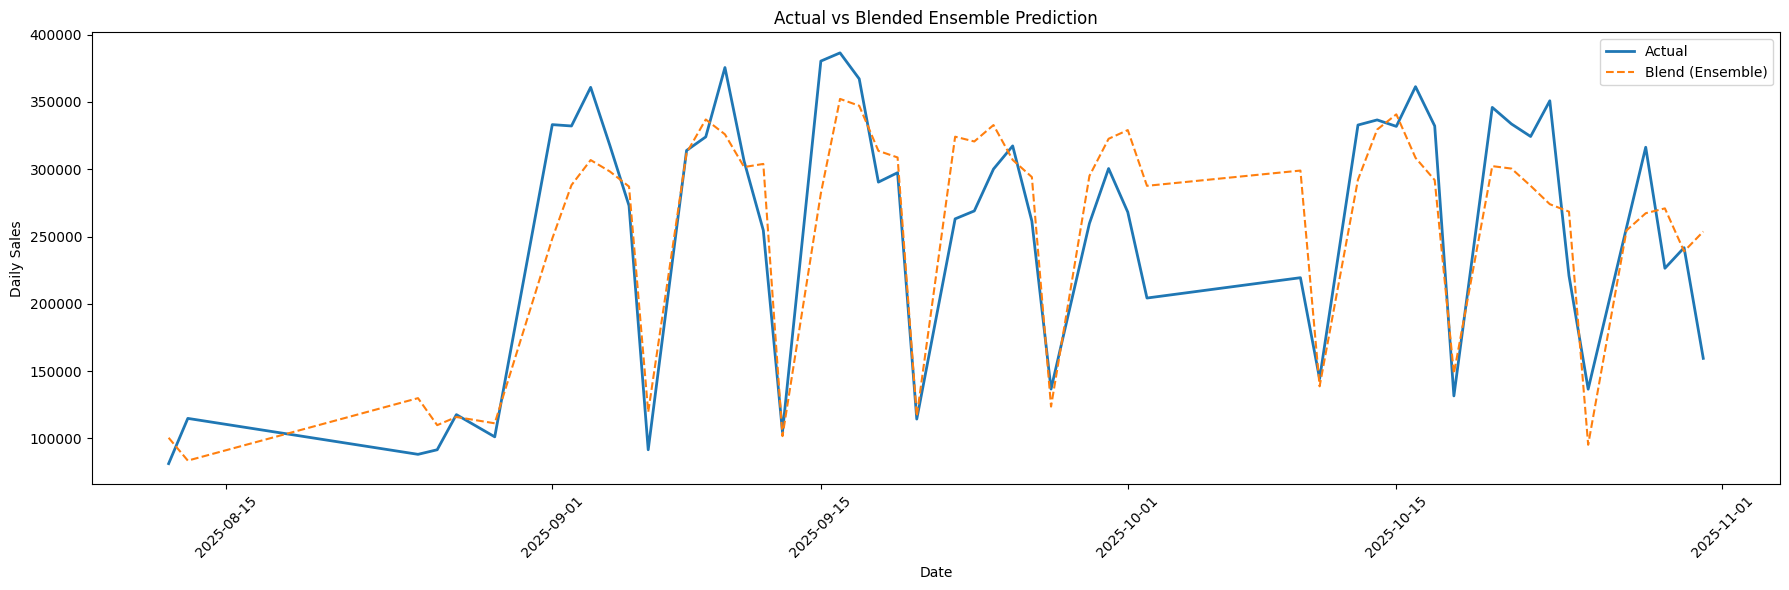


===== Blending 모델 가중치 (Feature Importances) =====
XGB   : 0.261687
LGBM  : 0.514157
LSTM  : 0.056388
GRU   : 0.057728
Intercept : -6238.731362


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from IPython.display import display


# ==========================================================
# 🔧 공통 함수: SMAPE
# ==========================================================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred) / 2)
    denom[denom == 0] = 1e-8
    return np.mean(np.abs(y_true - y_pred) / denom) * 100


# ==========================================================
# 🧠 전체 파이프라인 (4모델 실행 + 블렌딩)
# ==========================================================
def build_blend_model():
    # 1️⃣ 4개 모델 실행
    xgb_metrics, xgb_df = run_xgb()
    lgbm_metrics, lgbm_df = run_lgbm()
    lstm_metrics, lstm_df = run_lstm()
    gru_metrics, gru_df = run_gru()

    # 2️⃣ 컬럼 이름 통일
    xgb_df  = xgb_df.rename(columns={"pred_daily": "pred_xgb"})
    lgbm_df = lgbm_df.rename(columns={"pred_daily": "pred_lgbm"})
    lstm_df = lstm_df.rename(columns={"pred_daily": "pred_lstm"})
    gru_df  = gru_df.rename(columns={
        "daily_actual": "actual_daily",
        "예측매출": "pred_gru"
    })

    # 3️⃣ 공통 날짜 기준 inner join → 베이스 DataFrame 생성
    base = xgb_df[["date", "actual_daily", "pred_xgb"]].copy()
    base = base.merge(lgbm_df[["date", "pred_lgbm"]], on="date", how="inner")
    base = base.merge(lstm_df[["date", "pred_lstm"]], on="date", how="inner")
    base = base.merge(gru_df[["date", "pred_gru"]], on="date", how="inner")
    base = base.sort_values("date").reset_index(drop=True)

    print("\n===== 앙상블에 사용할 공통 구간 데이터 (샘플) =====")
    display(base.head())

    # 4️⃣ Linear Regression Blending 학습
    y_true = base["actual_daily"].values
    pred_matrix = base[["pred_xgb", "pred_lgbm", "pred_lstm", "pred_gru"]].values

    blender = LinearRegression()
    blender.fit(pred_matrix, y_true)
    pred_blend = blender.predict(pred_matrix)

    base["pred_blend"] = pred_blend

    # 5️⃣ 앙상블 성능 출력
    b_mae = mean_absolute_error(y_true, pred_blend)
    b_rmse = np.sqrt(mean_squared_error(y_true, pred_blend))
    b_smape = smape(y_true, pred_blend)

    print("\n===== [Linear Regression Blending] 최종 앙상블 성능 =====")
    print(f"MAE:   {b_mae:,.2f}")
    print(f"RMSE:  {b_rmse:,.2f}")
    print(f"SMAPE: {b_smape:.2f}%")

    # 6️⃣ Actual vs Ensemble Plot (원하면 주석 해제해서 사용)
    plt.figure(figsize=(18, 6))
    plt.plot(base["date"], base["actual_daily"], label="Actual", linewidth=2)
    plt.plot(base["date"], base["pred_blend"], label="Blend (Ensemble)", linestyle="--")
    plt.title("Actual vs Blended Ensemble Prediction")
    plt.xlabel("Date")
    plt.ylabel("Daily Sales")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return base, blender


# ==========================================================
# 🚀 실행
# ==========================================================
base_df, blend_model = build_blend_model()

print("\n===== Blending 모델 가중치 (Feature Importances) =====")
for name, w in zip(["XGB", "LGBM", "LSTM", "GRU"], blend_model.coef_):
    print(f"{name:5s} : {w:.6f}")
print(f"Intercept : {blend_model.intercept_:.6f}")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Recursive Prediction with Full Meta: 100%|██████████| 83/83 [00:00<00:00, 691.22it/s]



📈 LSTM 성능 검증 (4. Sales + Full Meta - Pure Recursive)
Validation Period: 2025-08-10 ~ 2025-10-31
1. MAE: 96,189.64 KRW
2. RMSE: 137,737.27 KRW
3. SMAPE: 42.56 %
🚀 Seed Ensemble 시작 (총 5개 모델 학습)...

[1/5] Seed 42 학습 중...

[2/5] Seed 100 학습 중...

[3/5] Seed 2024 학습 중...

[4/5] Seed 777 학습 중...

[5/5] Seed 999 학습 중...

🎯 앙상블 결과 집계 중...

📊 성능 평가 결과 (비교 데이터: 83개)
1. MAE   : 51,518.54
2. RMSE  : 82,083.14
3. SMAPE : 59.59 %

===== 앙상블에 사용할 공통 구간 데이터 (샘플) =====


,date,actual_daily,pred_xgb,pred_lgbm,pred_lstm,pred_gru
0,2025-08-12,81300.0,133386.937500,137720.119786,7763.156394,10314.023789
1,2025-08-13,114900.0,109400.281250,108119.283916,13629.211761,83190.315792
2,2025-08-25,88200.0,208598.625000,144717.737423,0.000000,124242.548158
3,2025-08-26,91600.0,176136.046875,128625.697426,1868.647831,65517.430037
4,2025-08-27,117700.0,192108.453125,127075.196508,864.941114,112913.387789



===== [Linear Regression Blending] 최종 앙상블 성능 =====
MAE:   34,015.60
RMSE:  42,423.36
SMAPE: 9.57%


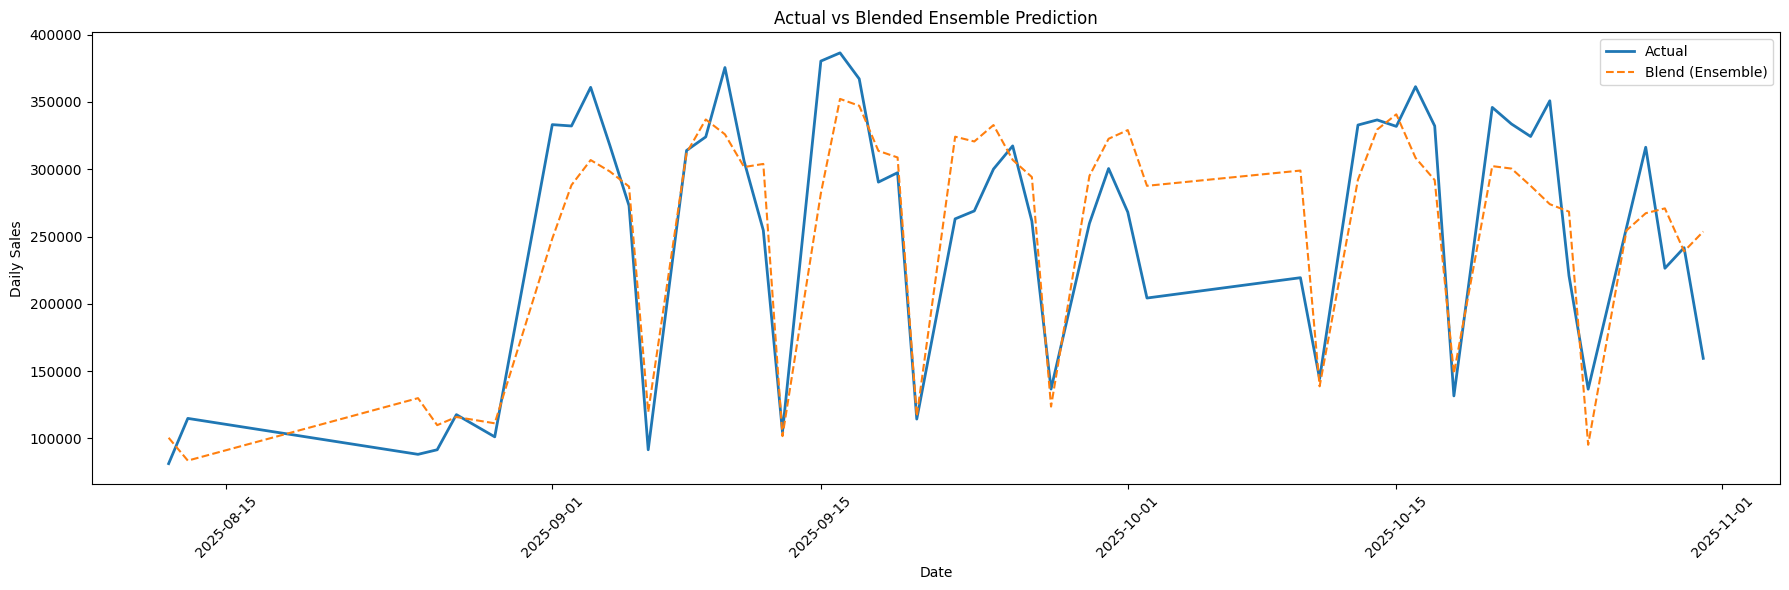


===== 📊 모델별 최종 성능 비교표 (MAE/RMSE/SMAPE) =====

  model        MAE       RMSE  SMAPE
    XGB  62,403.64  75,000.68 17.63%
   LGBM  44,631.46  55,309.77 12.55%
   LSTM 112,233.49 127,886.30 32.68%
GRU_ens  64,455.96  94,827.99 19.03%
  Blend  34,015.60  42,423.36  9.57%

===== 기본 4모델 + 앙상블 성능 비교 =====
  model           MAE          RMSE     SMAPE
    XGB  62403.640625  75000.680685 17.631832
   LGBM  44631.457215  55309.765342 12.554488
   LSTM 112233.486090 127886.302314 32.681213
GRU_ens  64455.960603  94827.993985 19.025989
  Blend  34015.597154  42423.355197  9.574223


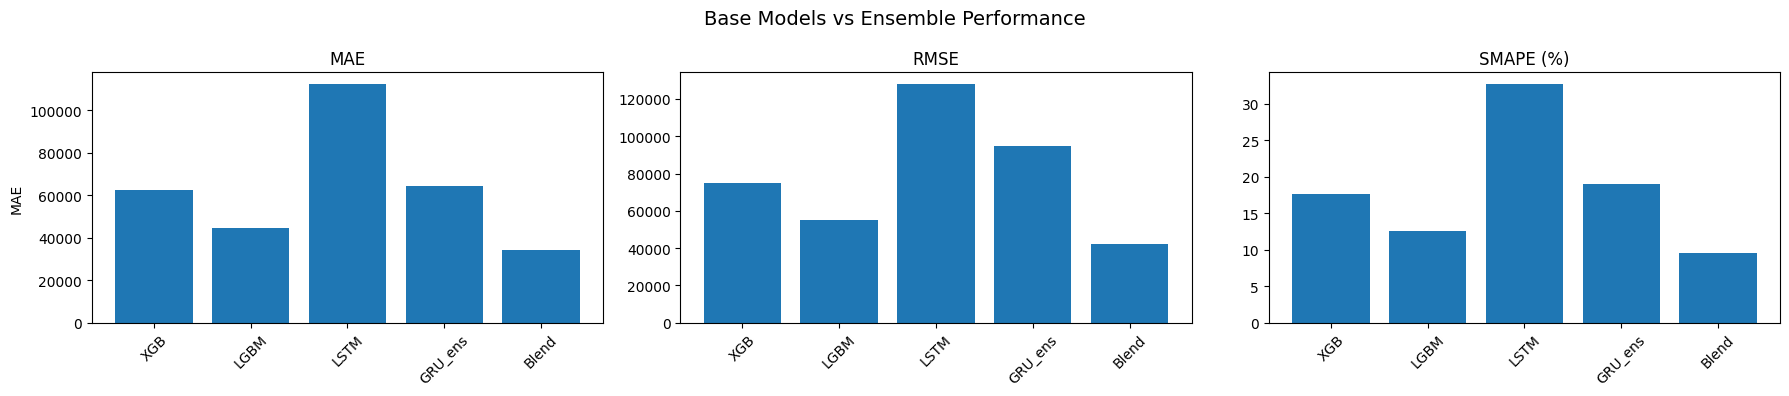

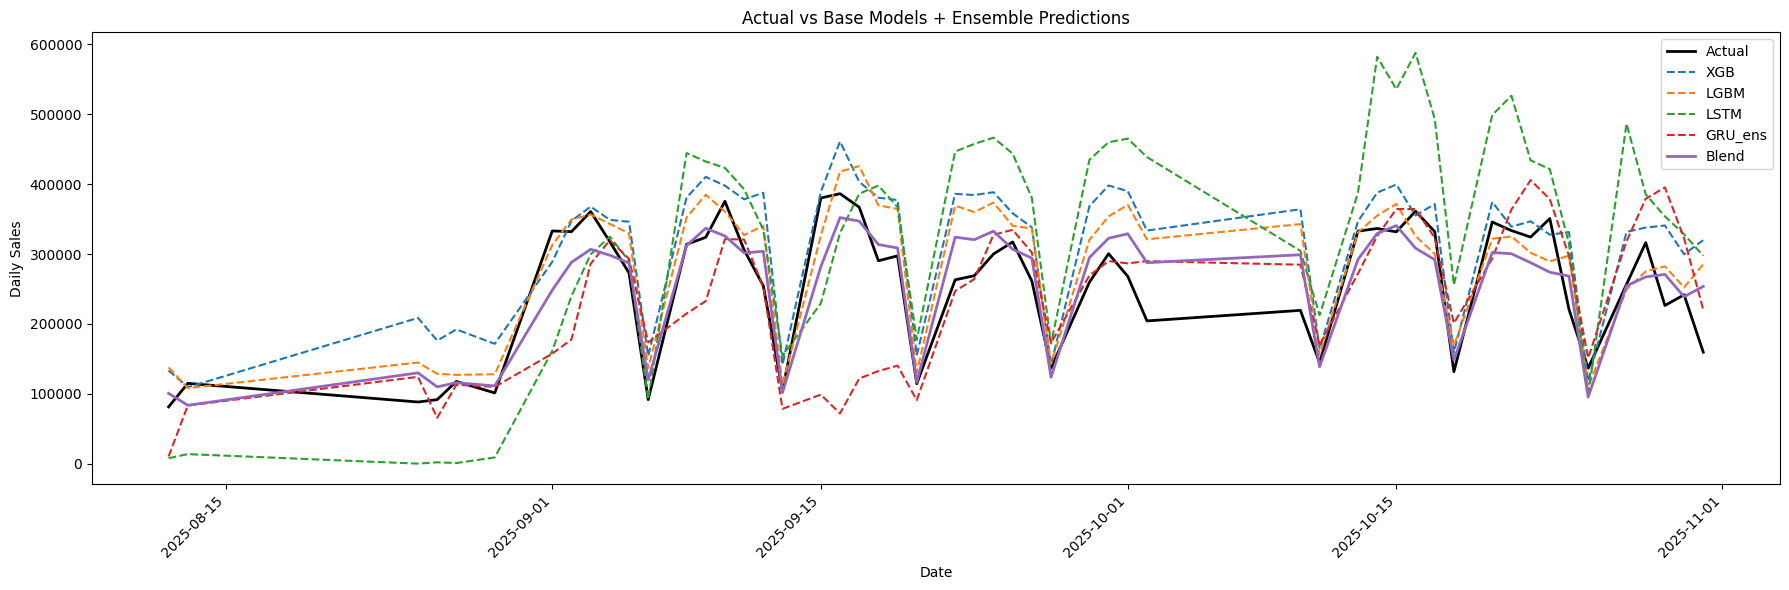

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 여기서는 ensemble_models import 필요 없음!
# build_blend_model(), smape 는 이미 위 셀에서 정의되어 있다고 가정


def main():
    # 1) ensemble_models에서 base_df, blend_model 가져오기
    base_df, blend_model = build_blend_model()

    # 2) 기본 4모델 + 앙상블 예측 벡터 정리
    y_true = base_df["actual_daily"].values

    preds_dict = {
        "XGB":      base_df["pred_xgb"].values,
        "LGBM":     base_df["pred_lgbm"].values,
        "LSTM":     base_df["pred_lstm"].values,
        "GRU_ens":  base_df["pred_gru"].values,
        "Blend":    base_df["pred_blend"].values,
    }

    # 3) 모델별 MAE / RMSE / SMAPE 계산
    rows = []
    for name, pred in preds_dict.items():
        mae = mean_absolute_error(y_true, pred)
        rmse = np.sqrt(mean_squared_error(y_true, pred))
        s = smape(y_true, pred)
        rows.append({"model": name, "MAE": mae, "RMSE": rmse, "SMAPE": s})

    metrics_df = pd.DataFrame(rows)

    # ====== 최종 성능 비교 표 (정렬 + 보기 좋게) ======
    print("\n===== 📊 모델별 최종 성능 비교표 (MAE/RMSE/SMAPE) =====\n")
    metrics_pretty = metrics_df.copy()
    metrics_pretty["MAE"]   = metrics_pretty["MAE"].map(lambda x: f"{x:,.2f}")
    metrics_pretty["RMSE"]  = metrics_pretty["RMSE"].map(lambda x: f"{x:,.2f}")
    metrics_pretty["SMAPE"] = metrics_pretty["SMAPE"].map(lambda x: f"{x:.2f}%")

    print(metrics_pretty.to_string(index=False))


    print("\n===== 기본 4모델 + 앙상블 성능 비교 =====")
    print(metrics_df.to_string(index=False))

    # 4) 바 차트로 성능 비교 (MAE / RMSE / SMAPE)
    models = metrics_df["model"].tolist()
    mae_vals = metrics_df["MAE"].tolist()
    rmse_vals = metrics_df["RMSE"].tolist()
    smape_vals = metrics_df["SMAPE"].tolist()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle("Base Models vs Ensemble Performance", fontsize=14)

    axes[0].bar(models, mae_vals)
    axes[0].set_title("MAE")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis="x", rotation=45)

    axes[1].bar(models, rmse_vals)
    axes[1].set_title("RMSE")
    axes[1].tick_params(axis="x", rotation=45)

    axes[2].bar(models, smape_vals)
    axes[2].set_title("SMAPE (%)")
    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # 5) 타임시리즈 비교
    plt.figure(figsize=(18, 6))
    plt.plot(base_df["date"], base_df["actual_daily"],
             label="Actual", linewidth=2, color="black")

    plt.plot(base_df["date"], base_df["pred_xgb"],   label="XGB",      linestyle="--")
    plt.plot(base_df["date"], base_df["pred_lgbm"],  label="LGBM",     linestyle="--")
    plt.plot(base_df["date"], base_df["pred_lstm"],  label="LSTM",     linestyle="--")
    plt.plot(base_df["date"], base_df["pred_gru"],   label="GRU_ens",  linestyle="--")
    plt.plot(base_df["date"], base_df["pred_blend"], label="Blend",    linewidth=2)

    plt.title("Actual vs Base Models + Ensemble Predictions")
    plt.xlabel("Date")
    plt.ylabel("Daily Sales")
    plt.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
